In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import itertools
from joblib import dump
# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Métodos de Validación
from sklearn.model_selection import train_test_split

# Modelos de Clasificación
from sklearn.tree import DecisionTreeClassifier

# Métricas para Clasificación
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# OverSampling y UnderSampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [3]:
df = pd.read_pickle(r'C:\Users\José\Desktop\proyecto_aviones\data\pickle\vuelos_limpio.pkl')

In [4]:
# Creamos la columna target y ya la binarizamos
df["llega_tarde"] = np.where(df['retraso_llegada'] > 15, 'si', 'no')
df['llega_tarde'] = df['llega_tarde'].map({'si': 1, 'no': 0})

In [5]:
# Eliminamos las columnas que no aportan información extra y retraso en la llegada para que no prediga el 100% de las veces y mes que solo tiene 1 valor
columnas_eliminar = [
    "latitude_destino",
    "latitude_origen",
    "longitude_destino",
    "longitude_origen",
    "codigo_aeropuerto_destino",
    "codigo_aeropuerto_origen",
    "direccion_destino",
    "direccion_origen",
    "retraso_llegada",
    "hora_llegada_real",
    "mes"
]
df.drop(columns=columnas_eliminar, inplace=True)


In [6]:
df["aerolinea"].unique()

array(['Envoy Air', 'SkyWest Airlines', 'PSA Airlines', 'Endeavor Air',
       'Mesa Airlines', 'Southwest Airlines', 'Allegiant Air',
       'American Airlines', 'Delta Air Lines', 'Frontier Airlines',
       'JetBlue Airways', 'Republic Airways', 'United Airlines',
       'Alaska Airlines', 'Hawaiian Airlines', 'Horizon Air',
       'Spirit Airlines'], dtype=object)

In [7]:
diccionario_costo = {
    'alto_costo': ["Delta Air Lines", "American Airlines", "United Airlines", "Alaska Airlines", "Hawaiian Airlines"],
    'medio_costo': ["Southwest Airlines", "JetBlue Airways"],
    'bajo_costo': ['Allegiant Air', 'Frontier Airlines', 'Spirit Airlines', 'Envoy Air', 'SkyWest Airlines', 'PSA Airlines', 
                'Endeavor Air', 'Mesa Airlines', 'Republic Airways', 'Horizon Air']}

def asignar_costo(aerolinea):
    for costo, aerolineas in diccionario_costo.items():
        if aerolinea in aerolineas:
            return costo

df['aerolinea'] = df['aerolinea'].apply(asignar_costo)

In [8]:
df["aerolinea"].unique()

array(['bajo_costo', 'medio_costo', 'alto_costo'], dtype=object)

In [9]:
pesos_categorias = {'alto_costo': 2, 'medio_costo': 1, 'bajo_costo': 0} 

df['aerolinea'] = df['aerolinea'].map(pesos_categorias)

In [10]:
df["aerolinea"].unique()

array([0, 1, 2], dtype=int64)

In [11]:
df.columns

Index(['aerolinea', 'fecha', 'numero_vuelo', 'numero_cola',
       'hora_salida_programada', 'hora_salida_real',
       'duracion_programada_vuelo', 'duracion_real', 'retraso_salida',
       'hora_despegue', 'tiempo_pista_salida', 'tiempo_retraso_aerolinea',
       'tiempo_retraso_clima', 'tiempo_retraso_sistema_aviacion',
       'tiempo_retraso_seguridad', 'ciudad_origen', 'estado_origen',
       'aeropuerto_origen', 'dia_semana', 'anio', 'fin_de_semana', 'festivos',
       'ciudad_destino', 'estado_destino', 'aeropuerto_destino',
       'distancia_millas', 'llega_tarde'],
      dtype='object')

In [12]:
df['numero_vuelo'].unique()

array([3632, 3647, 3723, ..., 8803, 5963, 6379], dtype=int64)

In [13]:
df.groupby('llega_tarde').size().reset_index()

,llega_tarde,0
0,0,1560966
1,1,131510


In [14]:
# Cambiamos a minutos las columnas horarias

df["hora_salida_real"] = df["hora_salida_real"].apply(lambda x: x.hour * 60 + x.minute)
df["hora_salida_programada"] = df["hora_salida_programada"].apply(lambda x: x.hour * 60 + x.minute)

df['hora_despegue'] = df['hora_despegue'].replace('24:00', '00:00')
df['hora_despegue'] = pd.to_datetime(df['hora_despegue'], format='%H:%M').dt.hour * 60 + pd.to_datetime(df['hora_despegue'], format='%H:%M').dt.minute

In [15]:
# Como da error el datetime de fecha, extraemos el día del mes, que es el único que nos falta, porque mes como todos tienen el mismo no hace falta
# y sobbreescribimos la columna de fecha, 

df['fecha'] = df['fecha'].dt.day

In [16]:
# Miramos las columnas object que tenemos que cambiar a numéricas para el modelo
columnas_categoricas = df.select_dtypes(include=["object"]).columns.tolist()
columnas_categoricas

['numero_cola',
 'ciudad_origen',
 'estado_origen',
 'aeropuerto_origen',
 'ciudad_destino',
 'estado_destino',
 'aeropuerto_destino']

Target Encoding o mean encoding: Reemplaza cada valor de la variable categórica con una estadística calculada a partir de la variable objetivo. 
- Es útil para variables categóricas con alta cardinalidad, pero puede causar overfitting si no se maneja adecuadamente. En casos de alta cardinalidad, el uso de codificaciones como one-hot encoding puede generar un gran número de columnas, lo que puede aumentar significativamente la dimensionalidad de los datos y hacer que los modelos sean más difíciles de entrenar y menos interpretables.

In [17]:
def target_encoding(df, columna_categorica, target):

    media_columna_con_target = df.groupby(columna_categorica)[target].mean()
    df[columna_categorica] = df[columna_categorica].map(media_columna_con_target)
    return df

# target_encoding(df, 'aerolinea', 'llega_tarde') esta ya no xk la he puesto un label encoding
target_encoding(df, 'numero_cola', 'llega_tarde')
target_encoding(df, 'ciudad_origen', 'llega_tarde')
target_encoding(df, 'estado_origen', 'llega_tarde')
target_encoding(df, 'aeropuerto_origen', 'llega_tarde')
target_encoding(df, 'ciudad_destino', 'llega_tarde')
target_encoding(df, 'estado_destino', 'llega_tarde')
target_encoding(df, 'aeropuerto_destino', 'llega_tarde')

,aerolinea,fecha,numero_vuelo,numero_cola,hora_salida_programada,hora_salida_real,duracion_programada_vuelo,duracion_real,retraso_salida,hora_despegue,...,aeropuerto_origen,dia_semana,anio,fin_de_semana,festivos,ciudad_destino,estado_destino,aeropuerto_destino,distancia_millas,llega_tarde
0,0,1,3632,0.102941,491,496,57,69,5,513,...,0.047962,2,2021,0,0,0.079497,0.081672,0.079497,159.757805,0
1,0,1,3647,0.053004,405,397,56,61,-8,410,...,0.047962,2,2021,0,0,0.079497,0.081672,0.079497,159.757805,0
2,0,1,3723,0.046512,887,878,54,67,-9,891,...,0.047962,2,2021,0,0,0.079497,0.081672,0.079497,159.757805,0
3,0,1,4192,0.026316,755,755,61,59,0,764,...,0.047962,2,2021,0,0,0.079497,0.081672,0.079497,159.757805,0
4,0,1,4311,0.071090,1116,1187,62,58,71,1199,...,0.047962,2,2021,0,0,0.079497,0.081672,0.079497,159.757805,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692471,0,30,4262,0.000000,988,1011,85,74,23,1029,...,0.000000,5,2023,1,0,0.047928,0.046260,0.047928,255.813380,0
1692472,0,31,4244,0.000000,1051,1046,83,64,-5,1055,...,0.000000,4,2021,0,0,0.047928,0.046260,0.047928,255.813380,0
1692473,0,31,4255,0.000000,335,393,84,80,58,423,...,0.000000,4,2021,0,0,0.047928,0.046260,0.047928,255.813380,0
1692474,0,31,4299,0.000000,420,420,78,70,0,438,...,0.000000,5,2022,1,0,0.047928,0.046260,0.047928,255.813380,0


In [18]:
df.columns

Index(['aerolinea', 'fecha', 'numero_vuelo', 'numero_cola',
       'hora_salida_programada', 'hora_salida_real',
       'duracion_programada_vuelo', 'duracion_real', 'retraso_salida',
       'hora_despegue', 'tiempo_pista_salida', 'tiempo_retraso_aerolinea',
       'tiempo_retraso_clima', 'tiempo_retraso_sistema_aviacion',
       'tiempo_retraso_seguridad', 'ciudad_origen', 'estado_origen',
       'aeropuerto_origen', 'dia_semana', 'anio', 'fin_de_semana', 'festivos',
       'ciudad_destino', 'estado_destino', 'aeropuerto_destino',
       'distancia_millas', 'llega_tarde'],
      dtype='object')

In [19]:
df['hora_salida_programada'].unique()

array([491, 405, 887, ...,  88, 120,  81], dtype=int64)

In [20]:
# HAY QUE ACABAR DE DEFINIRLAS, EN ALGUNAS TENGO DUDA

variables_discretas = ['aerolinea', 'fecha', 'numero_vuelo', 'numero_cola', 'hora_salida_programada', 'hora_salida_real', 'hora_despegue', 'ciudad_origen', 'estado_origen',
                       'aeropuerto_origen', 'hora_llegada_real', 'dia_semana', 'anio', 'fin_de_semana', 'festivos', 'ciudad_destino', 'estado_destino', 'aeropuerto_destino',
                       'llega_tarde']

variables_continuas = ['duracion_programada_vuelo', 'duracion_real', 'retraso_salida', 'tiempo_pista_salida', 'tiempo_retraso_aerolinea', 'tiempo_retraso_clima', 'tiempo_retraso_sistema_aviacion',
                       'tiempo_retraso_seguridad', 'distancia_millas']

In [21]:
# Para variables discretas (tanto numéricas como categóricas, toman un conjunto finito o numerable de valores)

def comparar_variable_discreta_con_target(dataframe, target_variable, variable_to_compare):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    sns.countplot(x=dataframe[variable_to_compare], ax=axes[0])
    sns.countplot(x=dataframe[variable_to_compare], hue=dataframe[target_variable], ax=axes[1])
    plt.show()

C:\Users\José\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\José\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


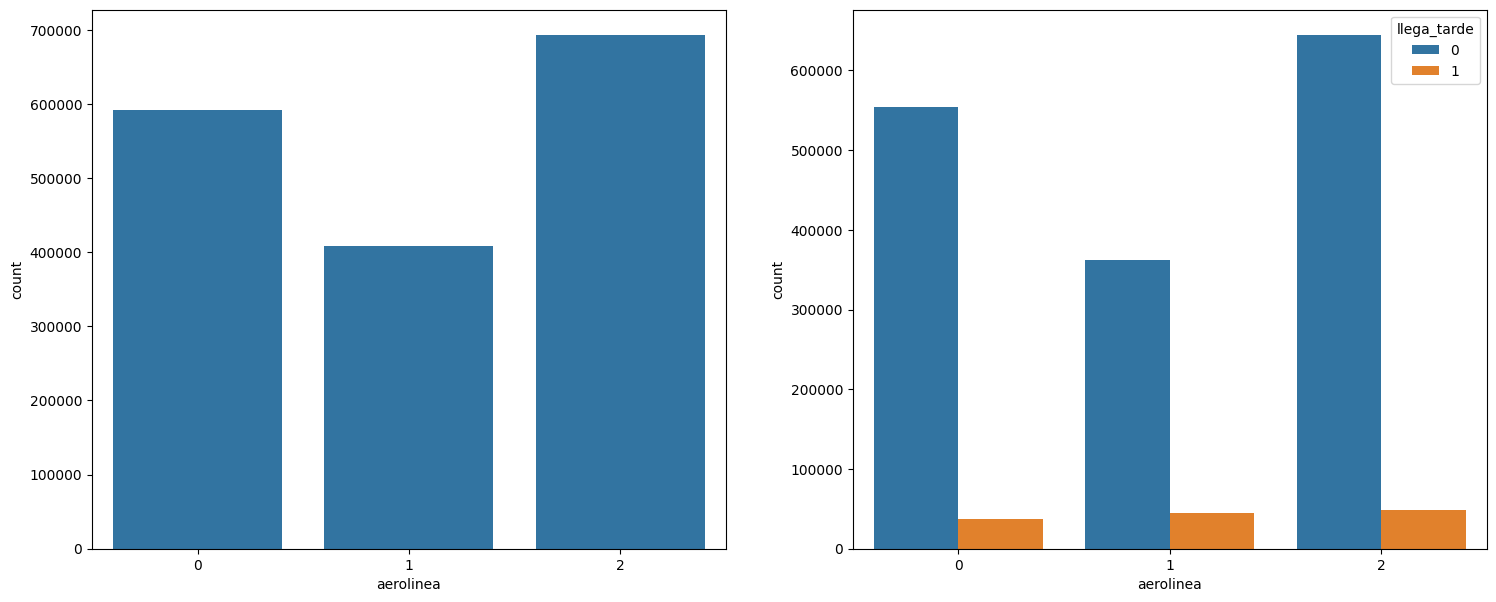

In [22]:
comparar_variable_discreta_con_target(df, "llega_tarde", "aerolinea")

In [23]:
# Para variables continuas (numéricas que pueden contener valores atípicos, que pueden variar dentro de un rango específico )
def comparar_variable_continua_con_target(dataframe, target_variable, variable_to_compare):
    fig, axes = plt.subplots(2, 2, figsize=(18, 11))
    sns.boxplot(x=dataframe[variable_to_compare], ax=axes[0, 0])
    axes[0, 0].set_title(f'{variable_to_compare} Boxplot')
    sns.histplot(x=dataframe[variable_to_compare], ax=axes[0, 1])
    axes[0, 1].set_title(f'{variable_to_compare} Histogram')
    sns.boxplot(x=dataframe[target_variable], y=dataframe[variable_to_compare], ax=axes[1, 0])
    axes[1, 0].set_title(f'{variable_to_compare} vs {target_variable}')
    sns.histplot(x=dataframe[variable_to_compare], hue=dataframe[target_variable], ax=axes[1, 1])
    axes[1, 1].set_title(f'{variable_to_compare} Histogram by {target_variable}')
    plt.tight_layout()
    plt.show()

C:\Users\José\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\José\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\José\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to

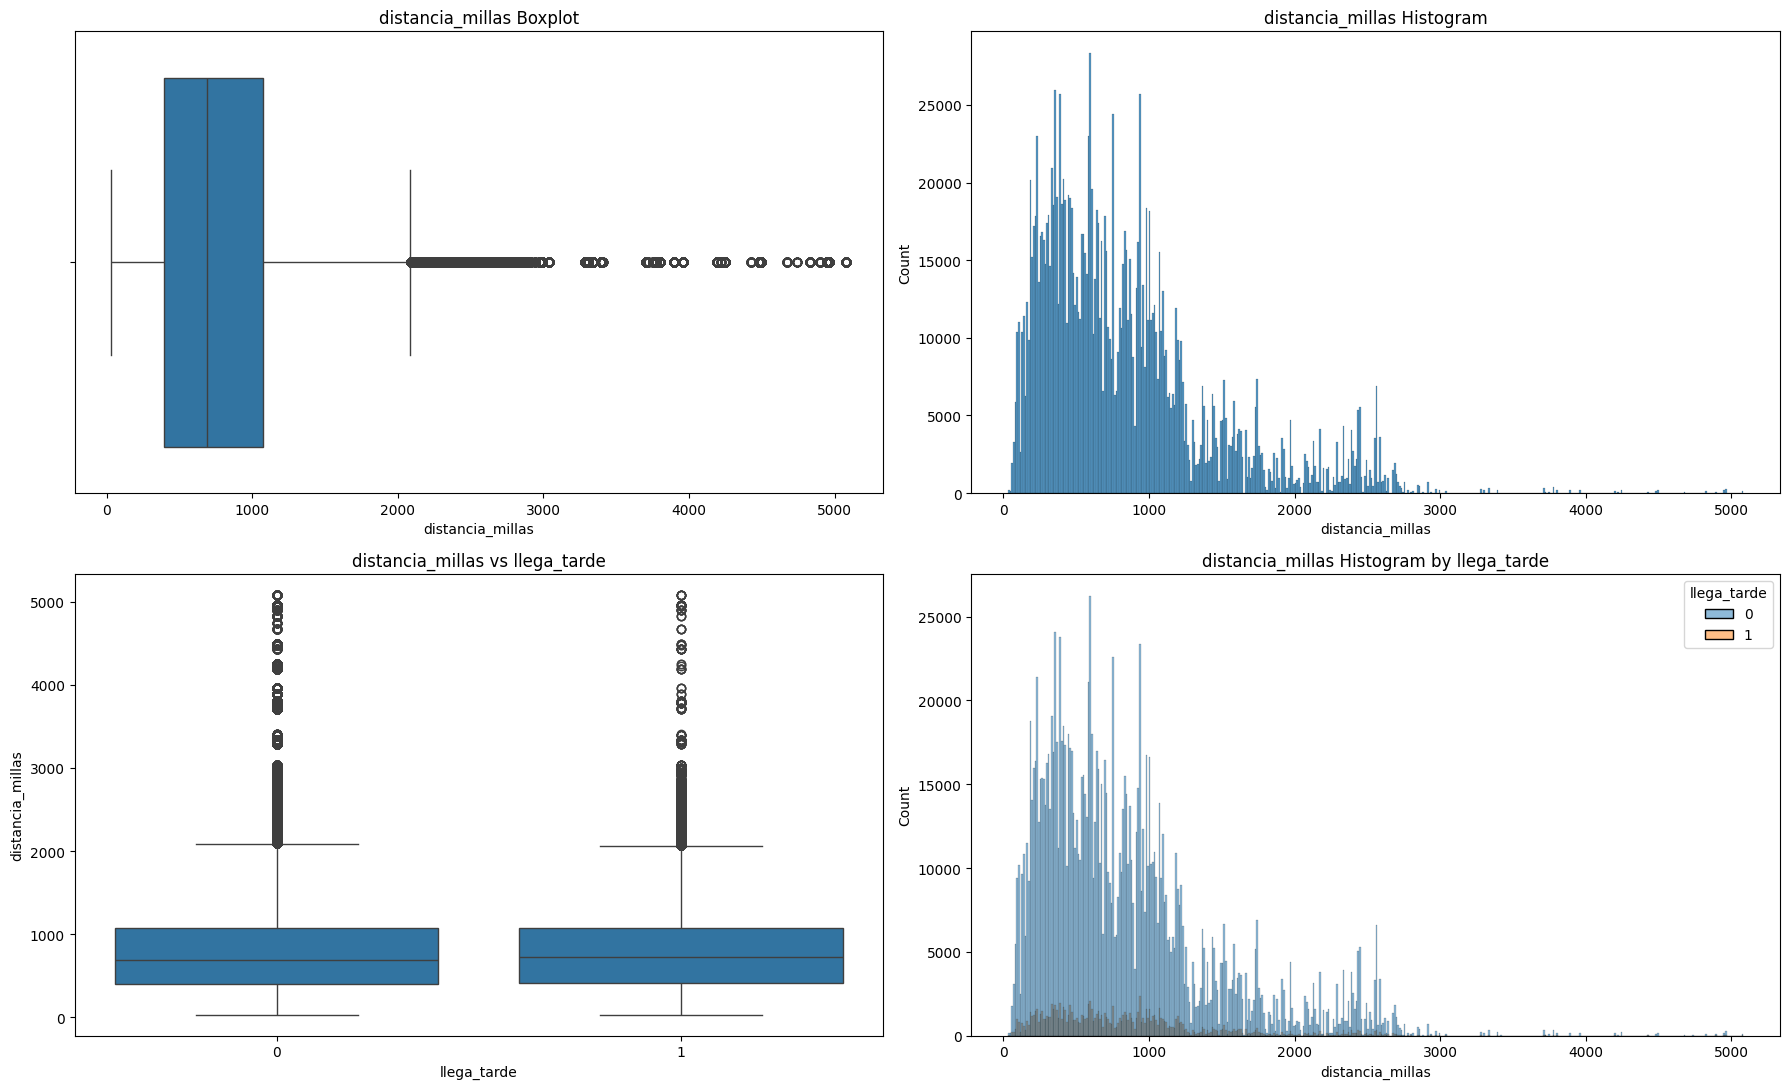

In [24]:
comparar_variable_continua_con_target(df, "llega_tarde", "distancia_millas")

In [25]:
# Aplicamos logaritmo.

df["distancia_millas"] = np.log(df["distancia_millas"] + 1) 

C:\Users\José\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\José\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\José\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to

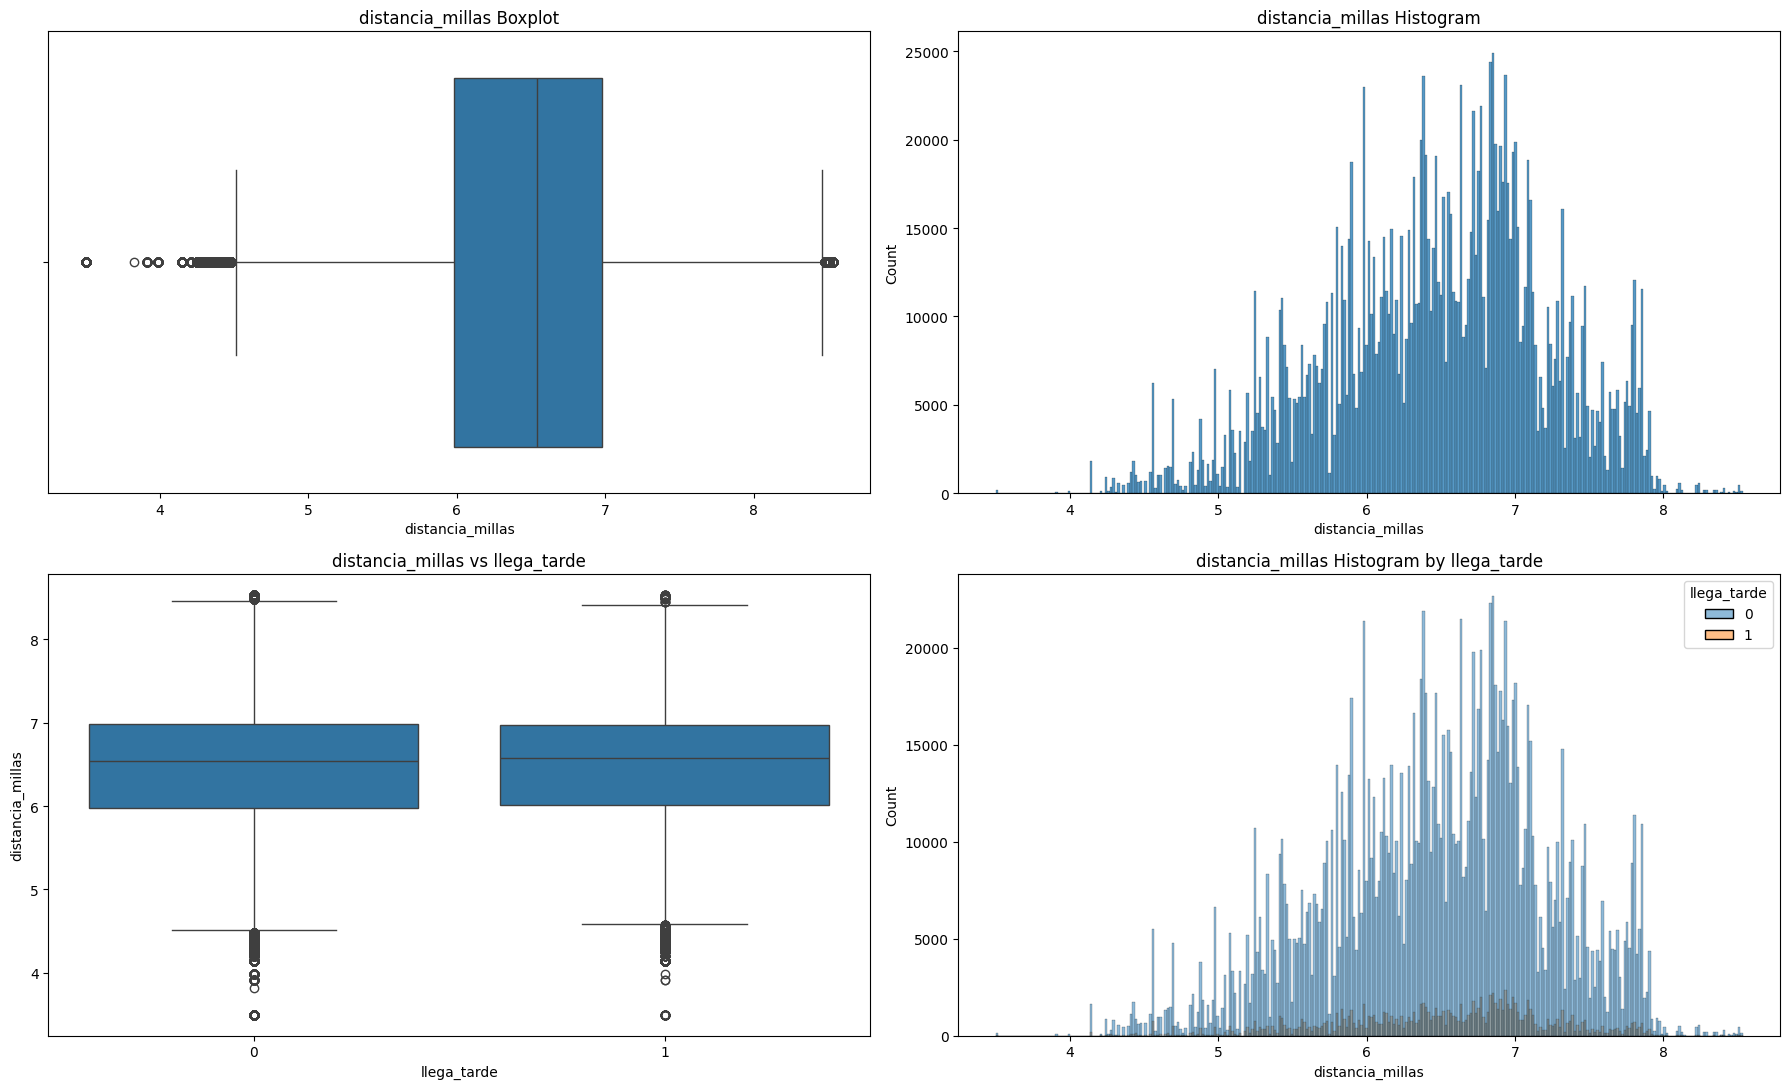

In [26]:
# grafico nuevamente con logaritmo
comparar_variable_continua_con_target(df, "llega_tarde", "distancia_millas")

## No se llego a aplicar quartiles, ya que en el estudio de las métricas, daba resultados peores eliminando outliers en las millas.

In [27]:
# Definimos la target

TARGET = "llega_tarde"
X = df.drop(columns = TARGET)
y  = df[[TARGET]]

In [28]:
# Definimos train y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (1353980, 26), y_train: (1353980, 1)
X_test: (338496, 26), y_test: (338496, 1)


In [29]:
# Analizamos la distribución de clases en el conjunto de datos. 

contador_clases= Counter([arr[0] for arr in list(y_train.values)])
print(contador_clases)

total = sum(contador_clases.values())
for clase, count in contador_clases.items():
    porcentaje = (count / total) * 100
    print(f'Porcentaje de "{clase}": {porcentaje:.2f}%')

Counter({0: 1248772, 1: 105208})
Porcentaje de "0": 92.23%
Porcentaje de "1": 7.77%


### Se necesita balancear las clases porque están desbalanceadas con la técnica SMOTE (Synthetic Minority Oversampling Technique).
### Vamos a hacerlo híbrido, combinando oversampling y undersampling.

In [30]:
# Definir las estrategias de balanceo
undersampling = RandomUnderSampler(sampling_strategy=0.1)
oversampling = SMOTE(sampling_strategy=0.6)

# Definir la pipeline
balance_pipeline = Pipeline([
    ('undersampling', undersampling),
    ('oversampling', oversampling)
])

# Aplicar la pipeline al conjunto de entrenamiento
X_balanceado, y_balanceado = balance_pipeline.fit_resample(X_train, y_train)

In [31]:
# Comprobamos que se han balanceado más 
contador_clases= Counter([arr[0] for arr in list(y_balanceado.values)])
print(contador_clases)

total = sum(contador_clases.values())
for clase, count in contador_clases.items():
    porcentaje = (count / total) * 100
    print(f'Porcentaje de "{clase}": {porcentaje:.2f}%')

Counter({0: 1052080, 1: 631248})
Porcentaje de "0": 62.50%
Porcentaje de "1": 37.50%


In [32]:
# INICIAMOS EL MODELO

model = DecisionTreeClassifier()
model.fit(X_balanceado, y_balanceado)

yhat = model.predict(X_test)
yhat

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [33]:
# VALORAMOS EL MODELO DE CLASIFICACIÓN CON LAS MÉTRICAS
jaccard_index = jaccard_score(y_test, yhat, average="macro")
accuracy = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat, average="macro")
recall = recall_score(y_test, yhat, average="macro")
f1_score_value = f1_score(y_test, yhat, average="macro")
roc_auc = roc_auc_score(y_test, yhat)
conf_matrix = confusion_matrix(y_test, yhat, labels=[0, 1])
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

print("Jaccard Index:", jaccard_score(y_test, yhat, average = "macro"))
print("Accuracy:"     , accuracy_score(y_test, yhat))
print("Precisión:"    , precision_score(y_test, yhat, average = "macro"))
print("Sensibilidad / Recall:" , recall_score(y_test, yhat, average = "macro"))
print("F1-score:"     , f1_score(y_test, yhat, average = "macro"))
print("ROC AUC / Área bajo la curva ROC:"  , roc_auc_score(y_test, yhat))
print("Matriz de Confusión:", conf_matrix)
print("Especificidad:", specificity)

Jaccard Index: 0.8886801980694186
Accuracy: 0.9816866373605596
Precisión: 0.9225731534934061
Sensibilidad / Recall: 0.9561255121034287
F1-score: 0.9385634839697854
ROC AUC / Área bajo la curva ROC: 0.9561255121034287
Matriz de Confusión: [[307945   4249]
 [  1950  24352]]
Especificidad: 0.9863898729636059


In [34]:
data = {'metric': ['Jaccard Index', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC', 'Specificity'],
        'value': [jaccard_index, accuracy, precision, recall, f1_score_value, roc_auc, specificity]}
df_metricas = pd.DataFrame(data)

In [35]:
df_metricas

,metric,value
0,Jaccard Index,0.888680
1,Accuracy,0.981687
2,Precision,0.922573
3,Recall,0.956126
4,F1-score,0.938563
5,ROC AUC,0.956126
6,Specificity,0.986390


In [36]:
fig = px.bar(df_metricas, x="Model", y=["Jaccard Index", "Accuracy", "Precision", "Recall", "F1-score", "ROC AUC", "Specificity"],
             title="Métricas de Evaluación de los Modelos de Aprendizaje Automático",
             labels={"value": "Valor de la Métrica", "variable": "Métrica"},
             barmode="group")
fig.update_layout(title_x=0.5, xaxis = {'categoryorder' : 'total descending'})
fig.show()

C:\Users\José\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [37]:
print(classification_report(y_test, yhat, digits = 3))

              precision    recall  f1-score   support

           0      0.994     0.986     0.990    312194
           1      0.851     0.926     0.887     26302

    accuracy                          0.982    338496
   macro avg      0.923     0.956     0.939    338496
weighted avg      0.983     0.982     0.982    338496



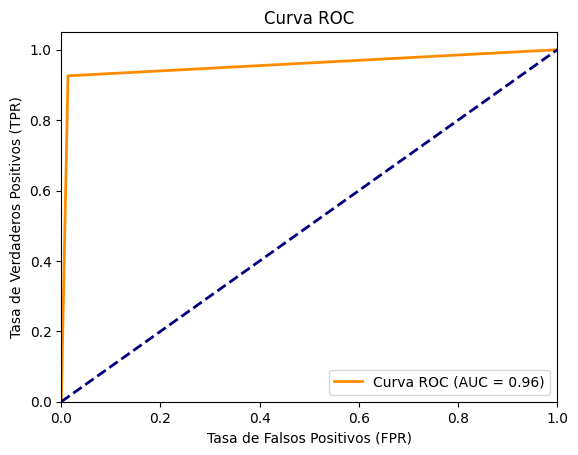

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, yhat)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Crear la gráfica
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


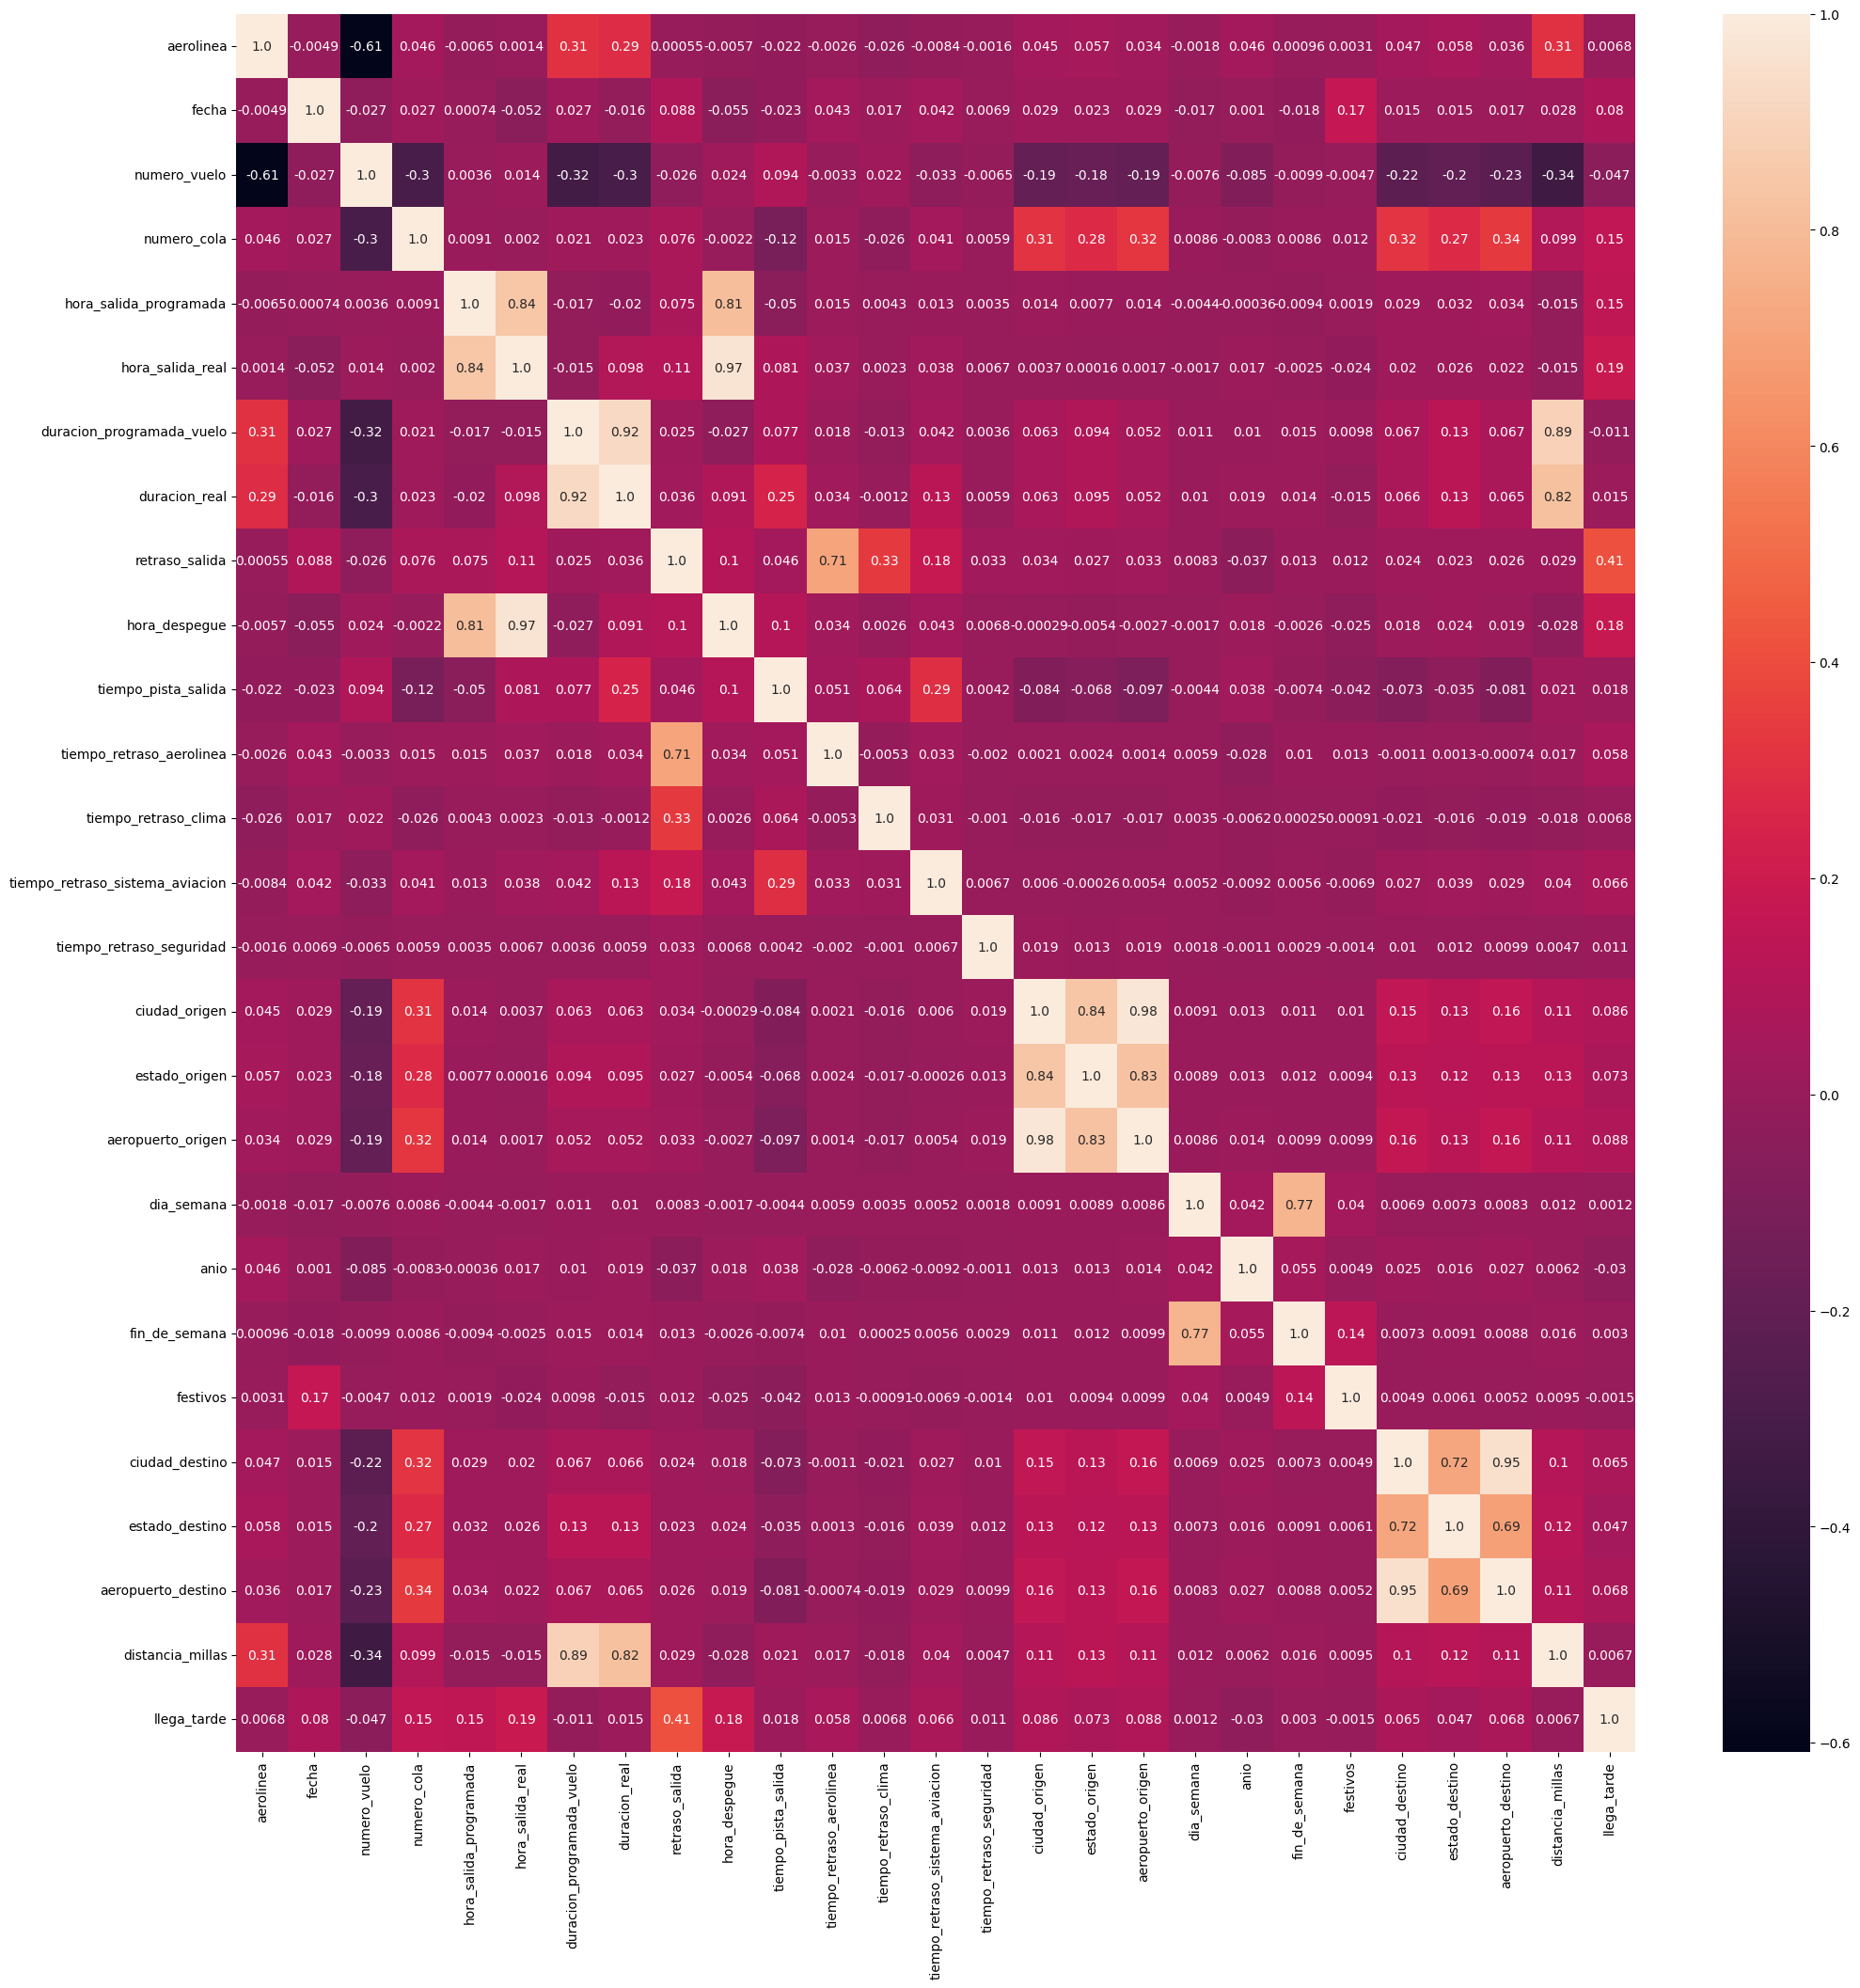

In [39]:
plt.figure(figsize=(24, 24))
sns.heatmap(df.corr(), annot=True, fmt=".2")
plt.show()

In [40]:
lista_columnas = df.columns

for i, j in itertools.combinations(lista_columnas, 2):
    corr_columnas = df[i].corr(df[j], method='pearson')
    
    if corr_columnas >= 0.5:
        print(f"Correlación entre {i} y {j}: {corr_columnas}")

Correlación entre hora_salida_programada y hora_salida_real: 0.8443752021464985
Correlación entre hora_salida_programada y hora_despegue: 0.809921380966439
Correlación entre hora_salida_real y hora_despegue: 0.9678073404380898
Correlación entre duracion_programada_vuelo y duracion_real: 0.923233505775255
Correlación entre duracion_programada_vuelo y distancia_millas: 0.8878972413729311
Correlación entre duracion_real y distancia_millas: 0.8227008881085758
Correlación entre retraso_salida y tiempo_retraso_aerolinea: 0.7091787064669292
Correlación entre ciudad_origen y estado_origen: 0.8423849049530009
Correlación entre ciudad_origen y aeropuerto_origen: 0.9800649894281271
Correlación entre estado_origen y aeropuerto_origen: 0.8279771231398473
Correlación entre dia_semana y fin_de_semana: 0.7724120491046511
Correlación entre ciudad_destino y estado_destino: 0.7165038608943377
Correlación entre ciudad_destino y aeropuerto_destino: 0.951573357610584
Correlación entre estado_destino y aerop

In [41]:
columna = TARGET

correlaciones = df.corr()[columna]

correlaciones_significativas = correlaciones[correlaciones > 0.2]

if len(correlaciones_significativas) > 0:
    print("Las siguientes columnas tienen una correlación mayor que 0.4 con '{}' :".format(columna))
    print(correlaciones_significativas.drop(columna).index.tolist())
else:
    print("No hay columnas con una correlación mayor que 0.4 con '{}'.".format(columna))

Las siguientes columnas tienen una correlación mayor que 0.4 con 'llega_tarde' :
['retraso_salida']


In [42]:
model.feature_importances_

array([1.80173061e-03, 2.57001294e-03, 4.18403436e-03, 8.10875054e-03,
       3.89007421e-03, 2.21298299e-03, 1.72686239e-02, 1.60609130e-02,
       7.94163063e-01, 2.62597705e-03, 4.89776259e-03, 8.43956105e-02,
       1.34395455e-02, 2.25194616e-02, 1.11460813e-03, 1.97813611e-03,
       2.98632348e-03, 1.88961779e-03, 1.21891540e-03, 1.87210209e-03,
       1.31338814e-03, 1.67231102e-04, 1.90601635e-03, 2.74235640e-03,
       2.07317390e-03, 2.59958790e-03])

In [43]:
for col, imp in zip(df, model.feature_importances_):
    print(f"Columna: {col} Importancia: {imp}")

Columna: aerolinea Importancia: 0.0018017306063469896
Columna: fecha Importancia: 0.002570012944285622
Columna: numero_vuelo Importancia: 0.004184034362624232
Columna: numero_cola Importancia: 0.008108750536462995
Columna: hora_salida_programada Importancia: 0.0038900742139436712
Columna: hora_salida_real Importancia: 0.0022129829902389113
Columna: duracion_programada_vuelo Importancia: 0.017268623865328923
Columna: duracion_real Importancia: 0.016060913021736126
Columna: retraso_salida Importancia: 0.7941630634324711
Columna: hora_despegue Importancia: 0.002625977046518141
Columna: tiempo_pista_salida Importancia: 0.004897762591979589
Columna: tiempo_retraso_aerolinea Importancia: 0.08439561054712028
Columna: tiempo_retraso_clima Importancia: 0.013439545482492427
Columna: tiempo_retraso_sistema_aviacion Importancia: 0.02251946156297807
Columna: tiempo_retraso_seguridad Importancia: 0.0011146081279402738
Columna: ciudad_origen Importancia: 0.001978136105592695
Columna: estado_origen Im

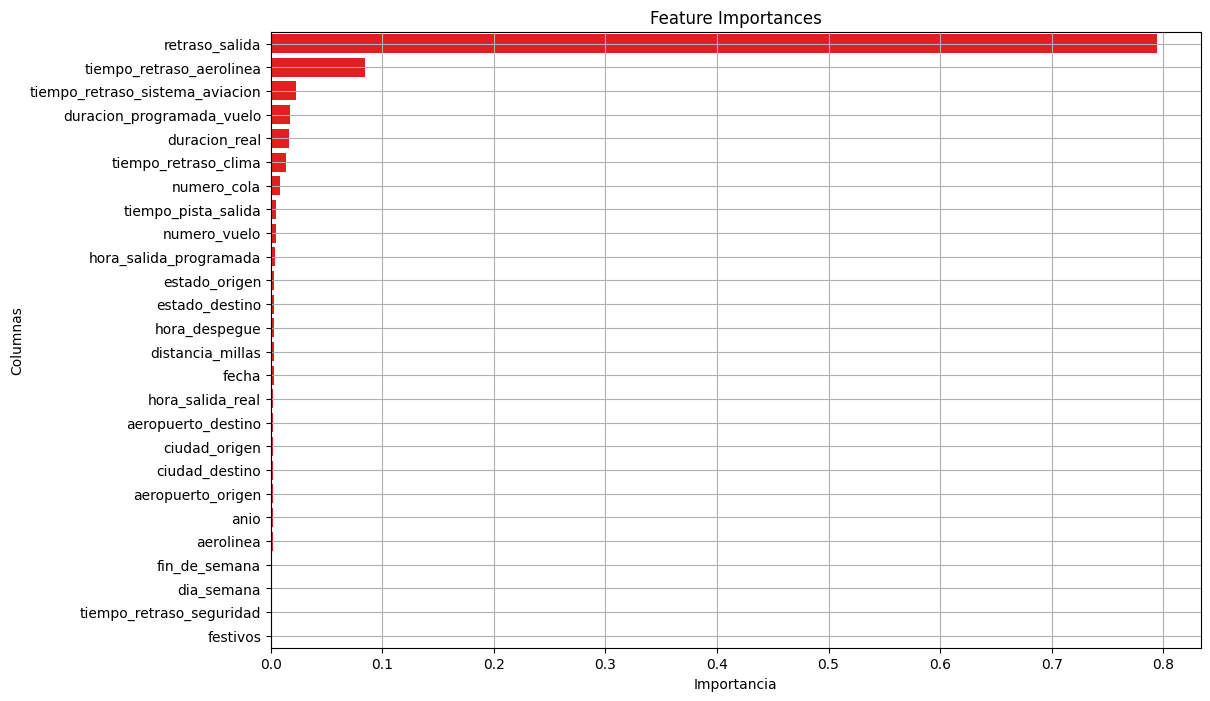

In [44]:
# MIRAMOS LA IMPORTANCIA DE LAS CLASES POR SI QUEREMOS QUITAR ALGUNA PARA VER SI MEJORA EL MODELO

importances = model.feature_importances_
df_importances = pd.DataFrame(data = zip(X.columns, importances),
                              columns = ["Columnas", "Importancia"])
df_importances = df_importances.sort_values("Importancia", ascending = False)
# print("Feature Importance:")
# for index, (feature, importance) in enumerate(df_importances.values):
#     print(f"{index + 1:2}. feature {index:2} ({importance:20}): {feature}")
plt.figure(figsize = (12, 8))
plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")
plt.grid()
plt.show()

In [45]:
#Guardamos el modelo
import pickle

with open('modelo_regresion.pkl', 'wb') as archivo:
    pickle.dump(model, archivo)
